In [ ]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, MetaData, Table
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA
from matplotlib import font_manager, rc
import platform
import requests
import matplotlib.pyplot as plt
import statsmodels.api as sm
from binance import Client
from statsmodels.tsa.stattools import adfuller, coint
from arch.unitroot import PhillipsPerron, KPSS, ADF
from scipy.stats import t, normaltest
from datetime import datetime, timedelta
import networkx as nx  # 그래프 기반 매칭을 위해 사용
from joblib import Parallel, delayed, parallel_backend
import numba
from tqdm import tqdm
from datetime import datetime
import threading
import warnings
from itertools import combinations
from numpy.linalg import inv
import time

warnings.filterwarnings("ignore")

# 운영체제에 따라 적절한 한글 폰트 설정
if platform.system() == 'Darwin':  # macOS의 경우
    rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

# 0. API 가져오기

In [2]:
import json

with open('./binance/api2.json', 'r') as f:
    api = json.load(f)

### API
binance_api_key = api['key']       #Enter your own API-key here
binance_api_secret = api['secret'] #Enter your own API-secret here

client = Client(binance_api_key, binance_api_secret)
# engine = create_engine('sqlite:///./crypto_0320.db')

# 1. 종목 리스트 불러오기
- coingecko 시가총액 기준 상위 200개 중 바이낸스에 상장된 코인들만 데이터 수집 진행
- 스테이블 코인 제외

In [4]:
EXCHANGE_INFO_URL = "https://fapi.binance.com/fapi/v1/exchangeInfo"
KLINES_URL = "https://fapi.binance.com/fapi/v1/klines"

# 1. 전체 선물 상품 목록 가져오기
response = requests.get(EXCHANGE_INFO_URL)
exchange_info = response.json()

# USDT 선물 상품(예: USDT 마진 계약)만 선택하는 예시
futures_symbols = [s["symbol"] for s in exchange_info["symbols"] if s["contractType"] in ["PERPETUAL"] and s["quoteAsset"] == "USDT"]

print(f"전체 종목 수: {len(futures_symbols)}")

전체 종목 수: 452


In [5]:
exchange_info = client.futures_exchange_info()
symbols = [s['symbol'] for s in exchange_info['symbols'] if (s['status'] == 'TRADING') and (s['symbol'][-4:] == 'USDT')]
print(f"총 선물 종목 수: {len(symbols)}")

총 선물 종목 수: 410


In [11]:
exchange_info = client.futures_exchange_info()
symbols = [s['symbol'] for s in exchange_info['symbols'] if (s['status'] == 'TRADING') and (s['symbol'][-4:] == 'USDT')]
print(f"총 선물 종목 수: {len(symbols)}")

current_time = int(time.time() * 1000)  # 현재 시간을 밀리초로 변환
start = current_time - (6 * 30 * 24 * 60 * 60 * 1000)  # 대략 6개월 전 타임스탬프

pd.to_datetime([start], unit='ms')

총 선물 종목 수: 410


DatetimeIndex(['2024-11-12 08:01:31.327000'], dtype='datetime64[ns]', freq=None)

In [80]:
for idx, sym in enumerate(futures_symbols):
    if sym == "1000SHIBUSDT":
        futures_symbols[idx] = "SHIBUSDT"
    elif sym == "1000LUNCUSDT":
        futures_symbols[idx] = "LUNCUSDT"
    elif sym == "1000PEPEUSDT":
        futures_symbols[idx] = "PEPEUSDT"
    elif sym == "1000FLOKIUSDT":
        futures_symbols[idx] = "FLOKIUSDT"
    elif sym == "LUNA2USDT":
        futures_symbols[idx] = "LUNAUSDT"

# 2. 바이낸스에서 데이터 수집하기

In [ ]:
from tqdm import tqdm
from datetime import datetime
import threading

db_lock = threading.Lock()

def getminutedata(symbol, days=1000, hours=0, minutes=0, option=False):

    if option:
        frame = pd.DataFrame(client.get_historical_klines(symbol, '5m', '2023-06-01', '2025-04-15'))
    else:
        if days == 0:
            if hours == 0:
                frame = pd.DataFrame(client.get_historical_klines(symbol, '5m', f'{minutes} minutes ago UTC'))
            else:
                frame = pd.DataFrame(client.get_historical_klines(symbol, '5m', f'{hours} hours {minutes} minutes ago UTC'))
        else:
            frame = pd.DataFrame(client.get_historical_klines(symbol, '5m', f'{days} days {hours} hours {minutes} minutes ago UTC'))
        
    frame = frame[[0, 1, 2, 3, 4]]
    frame.columns = ['Date', 'Open', 'High', 'Low', 'Close']
    frame.Date = pd.to_datetime(frame.Date, unit='ms')
    frame.set_index('Date', inplace=True)
    frame = frame.astype(float)
    return frame

def resampleOHLC(df, interval):
    df = df.resample(interval).agg({
        'Open' : 'first',
        'High' : 'max',
        'Low' : 'min',
        'Close' : 'last'
    })
    return df

def process_symbol(num, symbol, engine2):
    print(f"Currently working on {num}번째: {symbol} ...")
    try:
        with db_lock:
            origin_df = pd.read_sql(f"""SELECT * FROM '{symbol}'""", engine2)
        # 데이터베이스에서 해당 심볼의 기존 데이터를 읽어옴
        origin_df = pd.read_sql(f"""SELECT * FROM '{symbol}'""", engine2)
        origin_df['Date'] = pd.to_datetime(origin_df['Date'])
        origin_df.set_index('Date', drop=True, inplace=True)
        last_date = origin_df.index.max().strftime('%Y-%m-%d %H:%M:%S')    
        if last_date < '2025-04-15':
            time_diff = datetime.utcnow() - datetime.strptime(last_date, "%Y-%m-%d %H:%M:%S")
            days = time_diff.days
            hours, remainder = divmod(time_diff.seconds, 3600)
            minutes, seconds = divmod(remainder, 60)
    
            print(symbol, days, hours, minutes)
            try:
                new_data = getminutedata(symbol, days, hours, minutes)
                df_updated = pd.concat([origin_df, new_data], axis=0)
                df_updated = df_updated[~df_updated.index.duplicated(keep='last')]
                with db_lock:
                    df_updated.to_sql(symbol, engine2, if_exists='replace', index=True)
            except Exception as e:
                print(e, f"Passing {symbol} ...")
    except Exception as e:
        # 만약 해당 심볼에 테이블이 없으면 새로 생성
        try:
            get_df = getminutedata(symbol, option=True)
            with db_lock:
                get_df.to_sql(symbol, engine2, if_exists='replace', index=True)
        except Exception as e:
            print(e, f"Passing {symbol} ...")
            
# 기존 engine 생성 (멀티쓰레딩 환경에서는 engine 객체를 공유해도 무방함)
engine2 = create_engine('sqlite:///./crypto_0405.db')
# 테이블 이름(심볼) 목록 읽기
origin_symbols = pd.read_sql("""SELECT name FROM sqlite_schema WHERE type ='table'""", engine2).name.tolist()

# 멀티쓰레딩/병렬 처리로 각 심볼 업데이트 실행
with parallel_backend("threading", n_jobs=-1):
    Parallel(verbose=10)(
        delayed(process_symbol)(num, symbol, engine2) for num, symbol in enumerate(futures_symbols)
    )

## 2-1. DB에서 특정 종목 날리기

In [ ]:
meta = MetaData()
users = Table('LUNCUSDT', meta, autoload_with=engine2)
users.drop(engine2)

## 2-2. DB에서 특정 종목 확인하기

In [ ]:
# engine2 = create_engine('sqlite:///./crypto_0405.db')
origin_symbols = pd.read_sql("""SELECT name FROM sqlite_schema WHERE type ='table'""", engine2).name.tolist()
# origin_df = pd.read_sql("""SELECT * FROM 'BTCUSDT'""", engine2)
# origin_df.tail()
len(origin_symbols)

361

## 3. 유니버스 설정 (예: 상장한지 1년 반 이상) + 종목 기간 미달 드랍

In [ ]:
engine2 = create_engine('sqlite:///./crypto_0405.db')
symbols_universe = pd.read_sql("""SELECT name FROM sqlite_schema WHERE type ='table'""", engine2).name.tolist()

prices = pd.DataFrame()
for symbol in tqdm(symbols_universe):

    try:
        price = pd.read_sql(f"""SELECT * FROM '{symbol}'""", engine2)[['Date', 'Close']]
        condition = ((price['Date'] >= '2023-06-01 00:00:00.000000') & (price['Date'] <= '2025-04-15 00:00:00.000000'))
        price = price.loc[condition]
        price.set_index('Date', drop=True, inplace=True)
        price.rename(columns={'Close' : f'{symbol[:-4]}'}, inplace=True)
        prices = pd.concat([prices, price[f'{symbol[:-4]}']], axis=1)
    except Exception as e:
        print(e)

prices = prices.sort_index()
df_no_na_columns = prices.dropna(axis=1, how='any')
df_no_na_columns.head()
# engine = create_engine('sqlite:///./crypto_0320.db')
# prices.to_sql('gogogo', engine, if_exists='replace', index=True)
# engine = create_engine('sqlite:///./crypto_0403.db')
# df_no_na_columns.to_sql('mktcap', engine2, if_exists='replace', index=True)

100%|██████████| 361/361 [02:58<00:00,  2.02it/s]


,ETH,BTC,BCH,XRP,EOS,LTC,TRX,ETC,LINK,XLM,ADA,DASH,ZEC,XTZ,BNB,ATOM,ONT,IOTA,BAT,VET,NEO,QTUM,IOST,THETA,ALGO,ZIL,KNC,ZRX,COMP,DOGE,SXP,KAVA,BAND,RLC,MKR,SNX,DOT,YFI,CRV,TRB,RUNE,SUSHI,EGLD,SOL,ICX,STORJ,UNI,AVAX,ENJ,FLM,KSM,NEAR,AAVE,FIL,RSR,LRC,CVC,BEL,AXS,ALPHA,ZEN,SKL,GRT,1INCH,CHZ,SAND,ANKR,RVN,SFP,COTI,CHR,MANA,ALICE,HBAR,ONE,DENT,CELR,HOT,MTL,OGN,NKN,SC,DGB,BAKE,GTC,IOTX,RAY,C98,MASK,ATA,DYDX,GALA,CELO,AR,ARPA,CTSI,LPT,ENS,PEOPLE,ROSE,DUSK,FLOW,IMX,API3,GMT,APE,WOO,JASMY,OP,INJ,STG,SPELL,LDO,CVX,ICP,APT,QNT,FET,FXS,HOOK,MAGIC,T,HIGH,MINA,ASTR,PHB,GMX,CFX,STX,ACH,SSV,CKB,PERP,TRU,LQTY,USDC,ID,ARB,JOE,TLM,LEVER,RDNT,HFT,XVS,EDU,IDEX,SUI,UMA,RAD,NMR,MDT,XVG,AGLD,YGG,BNT,OXT,HIFI,GLMR,BICO,STPT,WAXP,RIF,POLYX,GAS,POWR,SLP,CAKE,TWT,STEEM,ILV,SUPER,USTC,ONG,AUCTION,MOVR,LSK,OM,GLM,RARE,SYN,SYS,VOXEL,ALPACA,SUN,MBOX,CHESS,FLUX,BSW,RPL,KDA,FIDA,FIO,GHST,LOKA,REI,COS,DIA,SANTOS,SCRT,AVA,DEGO,HIVE,DEXE,PHA,DF,PROM,VTHO,PAXG,FUN,MLN,FORTH,FLOKI,PEPE,LUNA,SHIB,BAL,CTK,LUNC,SNT,BADGER,VIDT,NULS,TROY
2023-06-01 00:00:00.000000,1875.63,27234.32,113.1,0.5156,0.891,90.54,0.07519,18.01,6.478,0.0924,0.3743,41.78,32.2,0.905,306.8,10.447,0.2222,0.1994,0.2130,0.02034,10.46,2.617,0.00917,0.833,0.1479,0.02281,0.607,0.2246,35.80,0.07163,0.4147,1.033,1.379,1.517,635.0,2.322,5.307,6484.0,0.817,11.45,1.125,0.838,36.83,20.82,0.2385,0.2938,5.025,14.10,0.3238,0.0820,26.50,1.563,63.8,4.684,0.002834,0.2785,0.0840,0.7915,6.86,0.1085,8.06,0.03274,0.1331,0.379,0.0989,0.5306,0.02541,0.02064,0.4106,0.0697,0.1509,0.4625,1.270,0.0512,0.01432,0.000855,0.01948,0.001583,1.004,0.0965,0.1149,0.00315,0.00763,0.1431,1.349,0.02297,0.2411,0.1880,4.373,0.1193,2.036,0.02935,0.503,6.57,0.06809,0.1817,4.97,9.97,0.01722,0.05193,0.1443,0.723,0.726,1.231,0.2562,3.145,0.2211,0.004557,1.383,7.191,0.6690,0.000594,2.090,4.175,4.667,8.3399,117.1,0.2638,6.520,1.3873,0.9510,0.02511,1.980,0.539,0.0493,0.8359,54.00,0.2864,0.5985,0.02884,23.50,0.00358,0.57517,0.0442,1.177,0.9998,0.46140,1.1597,0.4227,0.01511,0.001473,0.3022,0.4477,4.81,1.16553,0.07893,0.9741,1.934,1.891,14.27,0.05349,0.001910,0.443,0.1867,0.4133,0.0654,0.3304,0.2779,0.2816,0.04194,0.0526,0.1166,0.1411,2.793,0.1515,0.002145,1.636,1.0765,0.1816,52.55,0.1476,0.013480,0.2428,4.75,6.30,0.801,0.02753,0.2059,0.0912,0.5998,0.1251,0.1729,0.1948,0.00572,0.420,0.1782,0.544,0.1160,48.70,0.744,0.3300,0.02615,0.955,0.3428,0.02624,0.00566,0.2962,4.168,0.395,0.522,1.813,0.3441,2.415,0.1290,0.0481,4.29,0.001230,1968.0,0.005025,18.16,2.757,0.000031,0.000001,0.8302,0.000009,5.210,0.721,0.000085,0.02341,2.423,0.02957,0.2165,0.002536
2023-06-01 00:05:00.000000,1875.96,27241.68,113.2,0.5160,0.890,90.62,0.07518,18.01,6.478,0.0923,0.3746,41.76,32.2,0.903,306.8,10.443,0.2215,0.1992,0.2127,0.02035,10.45,2.612,0.00917,0.831,0.1479,0.02279,0.607,0.2243,35.80,0.07160,0.4139,1.031,1.377,1.514,634.0,2.319,5.306,6478.0,0.816,11.45,1.125,0.838,36.79,20.80,0.2381,0.2938,5.026,14.10,0.3237,0.0819,26.48,1.562,63.7,4.684,0.002832,0.2783,0.0839,0.7908,6.85,0.1085,8.04,0.03270,0.1341,0.379,0.0987,0.5296,0.02538,0.02064,0.4106,0.0696,0.1507,0.4626,1.270,0.0511,0.01432,0.000854,0.01945,0.001579,1.003,0.0963,0.1148,0.00315,0.00760,0.1429,1.347,0.02290,0.2506,0.1877,4.372,0.1190,2.035,0.02930,0.502,6.56,0.06806,0.1821,4.95,9.95,0.01719,0.05180,0.1441,0.721,0.725,1.229,0.2560,3.144,0.2202,0.004555,1.379,7.198,0.6692,0.000593,2.090,4.166,4.658,8.3420,117.2,0.2623,6.508,1.3847,0.9499,0.02511,1.965,0.537,0.0492,0.8353,53.81,0.2866,0.5975,0.02879,23.44,0.00357,0.57356,0.0439,1.175,0.9998,0.46188,1.1580,0.4220,0.01511,0.001467,0.3011,0.4465,4.81,1.15301,0.07897,0.9734,1.932,1.889,14.26,0.05320,0.001912,0.443,0.1862,0.4138,0.0654,0.3311,0.2778,0.2817,0.04187,0.0526,0.1165,0.1412,2.777,0.1514,0.002146,1.632,1.0761,0.1816,52.63,0.1478,0.013465,0.2428,4.74,6.30,0.803,0.02752,0.2048,0.0910,0.6024,0.1250,0.1726,0.1947,0.00571,0.419,0.1785,0.545,0.1160,48.72,0.743,0.3300,0.02612,0.955,0.3424,0.02612,0.00565,0.2957,4.159,0.394,0.521,1.815,0.3436,2.409,0.1287,0.0481,4.28,0.0

In [ ]:
df_no_na_columns.shape

(196993, 223)

In [ ]:
new_engine = create_engine('sqlite:///./crypto_0415_final.db')
df_no_na_columns.to_sql('all', new_engine, if_exists='replace', index=True)

196993

In [111]:
price.shape

(196993, 223)

## 4. 데이터 불러오기 + 리샘플링

In [ ]:
# engine = create_engine('sqlite:///./crypto_0320.db')

# price = pd.read_sql('gogogo', engine)
# price.drop('WBTC', axis=1, inplace=True)
# new_engine = create_engine('sqlite:///./crypto_0403.db')

price = pd.read_sql('all', new_engine)
price.rename(columns={'index' : 'Date'}, inplace=True)
price.set_index('Date', drop=True, inplace=True)
price.index = pd.to_datetime(price.index)
price.shape
# price_5min = price.resample('5min').last()
# price_15min = price.resample('15min').last()
# price_30min = price.resample('30min').last()
# price_1h = price.resample('1h').last()
# price_4h = price.resample('4h').last()
# price_1d = price.resample('1D').last()

(196993, 223)

In [ ]:
# 모든 행과 열을 출력하도록 옵션 설정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 혹은 출력 너비를 늘리기 위해서도 설정할 수 있습니다.
pd.set_option('display.width', 1000)

In [127]:
price.drop('USDC', axis=1, inplace=True)
price.shape

(196993, 222)

In [ ]:
class PairSelector:
    def __init__(self, prices):
        self.prices = prices
        self.pairs = self.generate_pairs()
        self.filtered_pairs_1 = []
        self.filtered_pairs_2 = []
        print(f"[PairSelector] 총 후보 페어 개수: {len(self.pairs)}")

    def generate_pairs(self):
        tickers = self.prices.columns.tolist()
        pairs = []
        for i in range(len(tickers)):
            for j in range(i+1, len(tickers)):
                pairs.append((tickers[i], tickers[j]))
        return pairs
 
    def filter_pairs_mr(self, pair):
        try:
            price1 = self.prices[pair[0]]
            price2 = self.prices[pair[1]]
            
            x = price2.values
            y = price1.values
            beta = np.cov(x, y, ddof=0)[0, 1] / np.var(x)
            alpha = np.mean(y) - beta * np.mean(x)
            spread = price1 - beta * price2 - alpha

            # 전체 기간에 대해 z-score 계산
            zscore = (spread - spread.mean()) / spread.std()

            # z-score가 극단치(절대값 >=2)에 도달한 후 0(또는 tol 이하)로 회귀하는 이벤트 횟수 측정
            event_count = self._count_mean_reversion_events(zscore.to_numpy(), threshold=3.5, tol=1)
            if event_count > 0:
                return (pair, event_count)

            # if event_count >= event_threshold:
            #     return pair
            # return None
        except Exception as e:
            print(f"Error in filter_pairs_mean_reversion for {pair}: {e}")
            return None
    
    @staticmethod
    @numba.njit
    def _count_mean_reversion_events(zscore_arr, threshold=1, tol=0.5):
        """
        Numba JIT 컴파일을 적용한 버전.
        zscore_arr: NumPy 배열 형태의 zscore 값들.
        threshold: 극단치 기준
        tol: 회귀(0에 가까운) 기준
        """
        count = 0
        in_extreme = False
        for i in range(len(zscore_arr)):
            val = zscore_arr[i]
            if not in_extreme:
                if np.abs(val) >= threshold:
                    in_extreme = True
            else:
                if np.abs(val) <= tol:
                    count += 1
                    in_extreme = False
        return count
    
    def run(self):
        corr_matrix = self.prices.corr()
        tickers = self.prices.columns.tolist()
        corr_pairs = []
        for i in range(len(tickers)):
            for j in range(i+1, len(tickers)):
                if abs(corr_matrix.loc[tickers[i], tickers[j]]) >= 0.6 and abs(corr_matrix.loc[tickers[i], tickers[j]]) <= 0.8:
                    corr_pairs.append((tickers[i], tickers[j]))
        print(f'첫 번째 필터 통과 페어 개수: {len(corr_pairs)}개')

        with parallel_backend("threading", n_jobs=-1):
            results2 = Parallel(verbose=1)(
                delayed(self.filter_pairs_mr)(pair) for pair in corr_pairs
            )
        results2 = [r for r in results2 if r is not None]
        # 이벤트 횟수(event_count)를 기준으로 내림차순 정렬하여 상위 20개 페어 선택
        results2_sorted = sorted(results2, key=lambda x: x[1], reverse=True)
        top_20 = results2_sorted[:30]
        top_20_list = []

        # for pair, count in top_20:
        #     top_20_list.append(pair)

        # # 가장 많이 등장하는 종목(자산)을 찾은 후, 해당 종목이 포함된 페어들만 필터링
        # from collections import Counter
        # asset_counter = Counter()
        # for pair in top_20_list:
        #     asset_counter.update(pair)
        # most_common_asset = asset_counter.most_common(1)[0][0]
        # filtered_pairs = [pair for pair in top_20_list if most_common_asset in pair]
        # return filtered_pairs
    
        # print(f'상위 20개 페어 (페어, 이벤트 횟수):')
        for pair, count in top_20:
            print(f'{pair} - 이벤트 횟수: {count}')
            top_20_list.append(pair)

        return top_20_list #corr_pairs#top_20_list

class BasePairSelector(PairSelector):

    def my_adf(self, y, maxlag=0):
        """
        Manual ADF test with constant term only (no lagged differences if maxlag=0).
        Returns the t-statistic on y_{t-1} coefficient.
        """
        y = np.asarray(y.dropna())
        n = len(y)
        # Δy_t = y_t - y_{t-1}
        dy = y[1:] - y[:-1]
        
        # Regressors: constant + y_{t-1}
        X = np.column_stack([np.ones(n-1), y[:-1]])
        
        # If maxlag > 0, include lagged Δy terms
        for lag in range(1, maxlag+1):
            X = np.column_stack([X, dy[lag-1:-(lag) if lag>0 else None]])
        
        # Align dependent variable
        Y = dy[maxlag:]
        X = X[maxlag:]
        
        # OLS: β = (X'X)^{-1} X'Y
        beta = inv(X.T @ X) @ (X.T @ Y)
        resid = Y - X @ beta
        sigma2 = (resid @ resid) / (len(Y) - X.shape[1])
        var_beta = sigma2 * inv(X.T @ X)
        
        # t-statistic for coefficient on y_{t-1} (index 1)
        t_stat = beta[1] / np.sqrt(var_beta[1,1])
        crit_vals = np.array([-3.430, -2.861, -2.567])
        p_levels = np.array([0.01, 0.05, 0.10])
        # if beyond table, clamp
        if t_stat <= crit_vals[0]:
            p_value = p_levels[0]
        elif t_stat >= crit_vals[-1]:
            p_value = 1.0
        else:
            # interp: as t increases, p increases
            p_value = float(np.interp(t_stat, crit_vals, p_levels))

        return p_value, t_stat
    
    def estimate_half_life(self, spread):
        delta_spread = spread.diff().dropna()  # ΔS_t = S_t - S_t-1 계산
        spread_lag = spread.shift(1).dropna()  # S_t-1 생성 (이전 시점의 스프레드)
        spread_lag, delta_spread = spread_lag.align(delta_spread, join='inner')  # ΔS_t와 S_t-1 맞춤

        # 회귀 분석 수행하여 θ 추정
        theta_model = sm.OLS(delta_spread, sm.add_constant(spread_lag)).fit()
        theta = -theta_model.params[0]  # θ 추정값 (음수 부호 주의)

        if theta > 0:
            halflife = np.log(2) / (theta) 
        else:
            halflife = np.nan

        return halflife

    def run(self):

        # 2) 페어 하나당 ADF 로직을 수행하는 헬퍼
        def _check_pair(pair):
            a, b = pair
            p1, p2 = self.prices[a], self.prices[b]
            beta = np.cov(p2, p1, ddof=0)[0,1] / np.var(p2)
            alpha = p1.mean() - beta * p2.mean()
            spread = p1 - beta * p2 - alpha

            halflife = self.estimate_half_life(spread)

            if halflife > 0:
                adf_res = adfuller(spread, autolag=None)
                pval, tstat = adf_res[1], adf_res[0]
            else:
                return None
            # my_pval, my_tstat = self.my_adf(spread)
            # print(f"Custom T-stats : {my_tstat}, Real T-stats : {tstat}, Custom p-val : {my_pval}, Real p-val : {pval}")

            if pval < 0.01:
                return (pair, halflife, alpha, beta)
            else:
                return None

        # 3) joblib 병렬 실행 (CPU 바운드라 default backend='loky' 권장)
        with parallel_backend("threading", n_jobs=-1):
            results = Parallel(verbose=1)(
                delayed(_check_pair)(pair)
                for pair in self.pairs
            )

        candidates = [r for r in results if r is not None]

        print(f"[PairSelector] ADF selector 통과 페어 개수: {len(results)}")        

        # 4) t-stat 작은 순으로 top_n
        top_pairs = [(pair, halflife, alpha, beta) for pair, halflife, alpha, beta in
                     sorted(candidates, key=lambda x: x[1])[:5]]
        print(f"[PairSelector] Base selector 통과 페어: {top_pairs}")
        return top_pairs

class HalfLifeEstimator:
    def __init__(self, prices, pairs):
        self.prices = prices
        self.pairs = pairs
        self.pair_stats = {}
        
    def estimate_half_life(self, spread):
        delta_spread = spread.diff().dropna()  # ΔS_t = S_t - S_t-1 계산
        spread_lag = spread.shift(1).dropna()  # S_t-1 생성 (이전 시점의 스프레드)
        spread_lag, delta_spread = spread_lag.align(delta_spread, join='inner')  # ΔS_t와 S_t-1 맞춤

        # 회귀 분석 수행하여 θ 추정
        theta_model = sm.OLS(delta_spread, sm.add_constant(spread_lag)).fit()
        theta = -theta_model.params[0]  # θ 추정값 (음수 부호 주의)

        if theta > 0:
            halflife = np.log(2) / (theta) 
        else:
            halflife = np.nan

        return halflife

    def filter_pairs_mr(self, pair):

        try:
            price1 = self.prices[pair[0]]
            price2 = self.prices[pair[1]]
            x = price2.values
            y = price1.values
            beta = np.cov(x, y, ddof=0)[0, 1] / np.var(x)
            alpha = np.mean(y) - beta * np.mean(x)
            spread = price1 - beta * price2 - alpha
            halflife = self.estimate_half_life(spread)
            #adf_result = adfuller(spread)

            if np.isfinite(halflife) and halflife > 0:
                return pair, {
                    'halflife': halflife, 
                    'alpha': alpha, 
                    'beta': beta, 
                    'spread': spread
                    # 'adf': adf_result[0],
                    # 'p-val' : adf_result[1]
                }
            else:
                return None, None
        except Exception as e:
            print(f"Error for pair {pair}: {e}")
            return None, None

    def select_pairs_graph(self, k):
        # 각 후보 페어에 대해 halflife, alpha, beta, spread, 분산 등을 계산
        with parallel_backend("threading", n_jobs=-1):
            results = Parallel(verbose=1)(
                delayed(self.filter_pairs_mr)(pair) for pair in self.pairs
            )
        """
        # G = nx.Graph()
        # for pair, stats_dict in results:

        #     if pair is not None and stats_dict is not None:

        #         if stats_dict['beta'] >= 0.25:
        #             u, v = pair
        #             # 가중치는 해당 페어의 halflife로 설정
        #             G.add_edge(u, v, weight=stats_dict['halflife'], stats=stats_dict)
        
        # # 최소 가중치 매칭을 구함 (각 노드가 단 한 번씩만 사용됨)
        # matching = nx.algorithms.matching.min_weight_matching(G, weight='weight')
        
        # # matching은 frozenset 형태의 두 종목 집합이므로 이를 리스트로 변환
        # matching_list = []
        # for edge in matching:
        #     u, v = tuple(edge)
        #     weight = G[u][v]['weight']
        #     stats_dict = G[u][v]['stats']
        #     matching_list.append(((u, v), weight, stats_dict))
        
        # # 가중치(halflife) 기준 오름차순 정렬 후 상위 k개 선택
        # matching_list = sorted(matching_list, key=lambda x: x[1])
        # selected = matching_list[:k]
        # selected_pairs = [(pair, stats) for (pair, weight, stats) in selected]

        # print(f"[HalfLifeEstimator.select_pairs_graph] 선택된 페어 수: {len(selected_pairs)}")
        # return selected_pairs
        """
        matching_list = []
        for pair, stats_dict in results:
            if pair is not None and stats_dict is not None:

                beta_val = stats_dict['beta']
                #p_val = stats_dict['p-val']
                if beta_val >= 0: # stats_dict['beta'] <= 4: # stats_dict['p-val'] <= 0.01 and  #and stats_dict['beta'] >= 0.2 and stats_dict['beta'] <= 1.8:
                    weight = stats_dict['halflife'] 
                    matching_list.append((pair, weight, stats_dict))

        print(f'halflife 필터에서 살아남은 페어의 개수는 {len(matching_list)}개입니다---------')

        matching_list = sorted(matching_list, key=lambda x: x[1])
        selected = matching_list[:k]
        selected_pairs = [(pair, stats) for (pair, weight, stats) in selected]
        # print(f"[HalfLifeEstimator.select_pairs_graph] 선택된 페어 수: {len(selected_pairs)}")
        return selected_pairs
    
class TradingStrategy:
    def __init__(self, prices, pair, alpha, beta, lookback, test_index, transaction_cost):
        self.prices = prices
        self.pair = pair
        self.lookback = lookback
        self.alpha = alpha
        self.beta = beta
        self.test_index = test_index
        self.transaction_cost = transaction_cost
        self.spread = None
        self.zscore = None
        self.positions = None
        self.zscore_st = None
        
    def calculate_spread(self):
        price1 = self.prices[self.pair[0]]
        price2 = self.prices[self.pair[1]]
        self.spread = price1 - self.beta * price2 - self.alpha  # 스프레드 계산

    def calculate_zscore(self):
        # EWMA 기반 z-score 계산
        spread_mean = self.spread.ewm(span=self.lookback, adjust=False).mean()
        spread_std = self.spread.ewm(span=self.lookback, adjust=False).std()
        # spread_mean = self.spread.rolling(self.lookback).mean()
        # spread_std = self.spread.rolling(self.lookback).std()
        self.zscore = (self.spread - spread_mean) / spread_std
        self.zscore = self.zscore[self.test_index]
        return self.zscore
    
    def generate_signals(self):
        self.positions = pd.DataFrame(index=self.zscore.index)
        self.zscore_st = self.zscore.ewm(span=self.lookback, adjust=False).std()
        upper_entry = self.zscore_st * 2
        lower_entry = -upper_entry
        upper_exit = self.zscore_st
        lower_exit = -upper_exit
        position_list = [0, 0]

        for t in range(2, len(self.zscore)):

            if t == len(self.zscore) - 1:
                position_list.append(0)
                continue

            current_z = self.zscore.iloc[t]
            z_t1 = self.zscore.iloc[t-1]
            z_t2 = self.zscore.iloc[t-2]
            current_signal = position_list[-1]

            #long entry
            if z_t1 < lower_entry.iloc[t-1] and z_t2 >= lower_entry.iloc[t-2] and current_z < lower_entry.iloc[t] and current_z > -5: # and self.zscore.iloc[t] > -4:
                new_signal = 1
            # Long Exit
            elif current_z > lower_exit.iloc[t] and z_t1 > lower_exit.iloc[t-1] and z_t2 <= lower_exit.iloc[t-2]:
                new_signal = 0
            #short entry
            elif z_t1 > upper_entry.iloc[t-1] and z_t2 <= upper_entry.iloc[t-2] and current_z > upper_entry.iloc[t] and current_z < 5: # and self.zscore.iloc[t] < 4:
                new_signal = -1
            # Short Exit
            elif current_z < upper_exit.iloc[t] and z_t1 < upper_exit.iloc[t-1] and z_t2 >= upper_exit.iloc[t-2]:
                new_signal = 0
            else:
                new_signal = current_signal

            """
            # current_date_str = self.zscore.index[t].strftime('%Y-%m-%d')
            # try:
            #     # price_1d는 전역에 정의되어 있고, pair[0]의 일별 가격 시리즈라고 가정합니다.
            #     pos = price_1d[self.pair[0]].index.get_loc(pd.Timestamp(current_date_str))
            #     if pos >= 7:
            #         prev_prices = price_1d[self.pair[0]].iloc[pos-7:pos]
            #         prev_list = prev_prices.values.tolist()
            #         # 3일 가격이 오름차순이면
            #         if (prev_list[-1]/prev_list[4] > 1.05) or (prev_list[-1]/prev_list[0] > 1.2):
            #             # 기존 entry 신호(1 또는 -1)를 반대로 변경
            #             print(f"Position changed from 1 to -1 at {self.zscore.index[t]} because of 3 green candles")
            #             if new_signal == 1:
            #                 new_signal = -1
            #             elif new_signal == -1:
            #                 new_signal = 1
            # except Exception as e:
            #     # 만약 일별 데이터 조회에 실패하면, 추가 조건 없이 기존 신호 유지
            #     pass


            # # Long Entry
            # if z_t1 < lower_entry.iloc[t-1] and z_t2 >= lower_entry.iloc[t-2]: # and self.zscore.iloc[t] > -4:
            #     new_signal = 1
            # # Long Exit
            # elif z_t1 > lower_exit.iloc[t-1] and z_t2 <= lower_exit.iloc[t-2]:
            #     new_signal = 0
            # # Short Entry
            # elif z_t1 > upper_entry.iloc[t-1] and z_t2 <= upper_entry.iloc[t-2]: # and self.zscore.iloc[t] < 4:
            #     new_signal = -1
            # # Short Exit
            # elif z_t1 < upper_exit.iloc[t-1] and z_t2 >= upper_exit.iloc[t-2]:
            #     new_signal = 0
            # else:
            #     new_signal = current_signal

            # # 추가된 위험 관리: 이미 포지션이 열려 있는 경우 위험 임계값 초과 시 강제 청산
            if current_signal == -1 and self.zscore.iloc[t] > risk_threshold_long: #.iloc[t]:
                new_signal = 0
                print(f"Stop-loss triggered at {self.zscore.index[t]} for long position: zscore {self.zscore.iloc[t]:.2f} > {risk_threshold_long:.2f}")
            if current_signal == 1 and self.zscore.iloc[t] < risk_threshold_short: #.iloc[t]:
                new_signal = 0
                print(f"Stop-loss triggered at index {self.zscore.index[t]} for short position: zscore {self.zscore.iloc[t]:.2f} < {risk_threshold_short:.2f}")
            """
            
            position_list.append(new_signal)
        self.positions['Position'] = position_list

class BaseTradingStrategy(TradingStrategy):

    def calculate_zscore(self):
        spread_mean = self.spread.mean()
        spread_std = self.spread.std()
        self.zscore = (self.spread - spread_mean) / spread_std
        self.zscore = self.zscore[self.test_index]
        return self.zscore

    def generate_signals(self):
        self.positions = pd.DataFrame(index=self.zscore.index)
        pos = [0]
        for t in range(1, len(self.zscore)):
            z = self.zscore.iloc[t]
            prev = pos[-1]
            if prev==0:
                if z>2:      curr = -1
                elif z<-2:   curr = 1
                else:        curr = 0
            elif prev==1 and z>=0:
                curr = 0
            elif prev==-1 and z<=0:
                curr = 0
            else:
                curr = prev
            pos.append(curr)
        self.positions['Position'] = pos

class Backtester:
    def __init__(self, prices, start_date, end_date, transaction_cost=0.0005):
        self.prices = prices
        self.start_date = start_date
        self.end_date = end_date
        self.transaction_cost = transaction_cost
        self.results = pd.DataFrame()
        self.trade_logs = []  # 각 구간별 거래 로그 저장
        print(f"[Backtester] 초기화: {start_date} ~ {end_date}, 수수료: {transaction_cost}")

    def run_backtest(self, ref_days=180, trade_days=7, initial_capital=10000):
        start_dt = datetime.strptime(self.start_date, "%Y-%m-%d")
        end_dt = datetime.strptime(self.end_date, "%Y-%m-%d")
        backtest_start = start_dt + pd.Timedelta(days=ref_days)
        date_range = pd.date_range(start=backtest_start, end=end_dt, freq=f'{trade_days}d')

        if date_range[-1] < end_dt:
            date_range = date_range.append(pd.DatetimeIndex([end_dt]))

        df_portfolio = pd.DataFrame({'Exit Time' : [date_range[0]], 'Cumulative Return (%)' : [0]})
        fixed_capital = initial_capital

        for i in range(len(date_range) - 1): #

            test_start = date_range[i]
            test_end = date_range[i+1]
            train_end = test_start
            train_start = train_end - pd.Timedelta(days=ref_days)
            print(f"\n[Backtester.run_backtest] LOOKBACK: {train_start.date()} ~ {train_end.date()} | Trade: {test_start.date()} ~ {test_end.date()}")

            train_data = self.prices.loc[train_start:train_end]
            test_data = self.prices.loc[test_start:test_end]
            new_train_data = np.log(train_data)
            new_test_data = np.log(test_data)
            combined_data = pd.concat([new_train_data, new_test_data.iloc[1:]])
            print(f"[Backtester.run_backtest] 학습+테스트 데이터 준비 완료, 길이: {len(combined_data)}")

            pair_selector = PairSelector(new_train_data)
            filtered_pairs = pair_selector.run()
            print(f"[Backtester.run_backtest] 필터 통과 페어 수: {len(filtered_pairs)}")

            half_life_estimator = HalfLifeEstimator(new_train_data, filtered_pairs)
            sorted_pairs = half_life_estimator.select_pairs_graph(5)

            n_pairs = len(sorted_pairs)
            if n_pairs == 0:
                print(f"[Backtester.run_backtest] 선정된 페어 없음; 구간 스킵")
                continue
            else:
                print(f"[Backtester.run_backtest] 여러 페어 선택: {n_pairs}개, 전체 시작 자본: {initial_capital}")

            all_signals = {}
            all_beta = {}

            """

            # n_pairs = len(sorted_pairs)
            # pair_capitals = { pair: initial_capital / n_pairs for pair, stats_dict in sorted_pairs }

            # for pair, stats_dict in sorted_pairs:

            #     print(f"[Backtester.run_backtest] 페어 {pair} 거래 구간 시작, Lookback = {int(round(stats_dict['halflife']))}")
            #     current_capital = pair_capitals[pair]
            #     strategy = TradingStrategy(combined_data, pair, stats_dict['alpha'], stats_dict['beta'], int(round(stats_dict['halflife'])), new_test_data.iloc[1:].index, self.transaction_cost) #int(round(stats_dict['halflife']))
            #     strategy.calculate_spread()
            #     strategy.calculate_zscore()
            #     strategy.generate_signals()
            #     signals = strategy.positions

            #     if initial_capital == fixed_capital:
            #         trade_df = record_trades(signals, test_data, pair, stats_dict['beta'], self.transaction_cost, current_capital)
            #     else:
            #         trade_df = record_trades(signals, test_data, pair, stats_dict['beta'], self.transaction_cost, current_capital, cum_returns)

            #     plot_trade_details(test_data, strategy, signals, trade_df, pair)
                
            #     if not trade_df.empty:
            #         print("\n=== Trade Records ===")
            #         print(trade_df)
            #         cum_returns = trade_df['Cumulative Return (%)'].iloc[-1]
            #         updated_capital = trade_df['Capital'].iloc[-1]
            #         pair_capitals[pair] = updated_capital
            #         print(f"  페어 {pair}: 업데이트된 자본 = {updated_capital:.2f}")
            #         print(f"[Backtester.run_backtest] 페어: {pair} 해당 구간 누적 수익률: {trade_df['Cumulative Return (%)'].iloc[-1]:.4f}%")
            #     else:
            #         print(f"  페어 {pair}: 거래 기록 없음, 자본 유지")
                
            
            # total_capital = sum(pair_capitals.values())
            # cumulative_return = (total_capital / fixed_capital) - 1
            # print(f"[Backtester.run_backtest] 구간 {i+1} 후 전체 포트폴리오 자본: {total_capital:.2f}, 누적 수익률: {cumulative_return*100:.2f}%")
            # df_portfolio = pd.concat([df_portfolio, pd.DataFrame({'Exit Time' : [test_end], 'Cumulative Return (%)' : [cumulative_return]})], ignore_index=True)
            # initial_capital = total_capital

            """

            for pair, stats_dict in sorted_pairs:

                print(f"[Backtester.run_backtest] 페어 {pair} 거래 구간 시작, beta값 : {stats_dict['beta']}, Lookback = {int(round(stats_dict['halflife']))}")
                strategy = TradingStrategy(combined_data, pair, stats_dict['alpha'], stats_dict['beta'], int(round(stats_dict['halflife'])), new_test_data.iloc[1:].index, self.transaction_cost) #int(round(stats_dict['halflife']))
                strategy.calculate_spread()
                strategy.calculate_zscore()
                strategy.generate_signals()
                all_signals[pair] = strategy.positions
                all_beta[pair] = stats_dict['beta']

            trade_df = integrated_record_trades(all_signals, test_data, self.transaction_cost, all_beta, capital=initial_capital/n_pairs)

            # plot_trade_details(test_data, strategy, signals, trade_df, pair)
            
            if not trade_df.empty:
                print("\n=== Trade Records ===")
                print(trade_df)
                updated_capital = trade_df['Total Capital'].iloc[-1]
                initial_capital = updated_capital
            else:
                print(f"  페어 {pair}: 거래 기록 없음, 자본 유지")
                
            
            total_capital = initial_capital
            cumulative_return = (total_capital / fixed_capital) - 1
            print(f"[Backtester.run_backtest] 구간 {i+1} 후 포트폴리오 자본: {total_capital:.2f}, 누적 수익률: {cumulative_return*100:.2f}%")
            df_portfolio = pd.concat([df_portfolio, pd.DataFrame({'Exit Time': [test_end], 'Cumulative Return (%)': [cumulative_return]})], ignore_index=True)
        
        df_portfolio.set_index('Exit Time', inplace=True)
        plt.figure(figsize=(12, 6))
        plt.plot(df_portfolio.index, df_portfolio['Cumulative Return (%)']*100, label='Cumulative Return (%)', lw=2)
        plt.xlabel('Time')
        plt.ylabel('Cumulative Return (%)')
        plt.title('Cumulative Return (%) Over All Trade Periods')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        overall_capital = initial_capital
        overall_return = (overall_capital / fixed_capital) - 1
        print(f"\n=== 전체 포트폴리오 최종 자본: {overall_capital:.2f}, 누적 수익률: {overall_return*100:.2f}% ===")
        return df_portfolio
        #return all_signals, test_data, all_beta

    def run_baseline_backtest(self, ref_days=180, trade_days=7, initial_capital=10000):
        start_dt = datetime.strptime(self.start_date, "%Y-%m-%d")
        end_dt = datetime.strptime(self.end_date, "%Y-%m-%d")
        backtest_start = start_dt + pd.Timedelta(days=ref_days)
        date_range = pd.date_range(start=backtest_start, end=end_dt, freq=f'{trade_days}d')

        if date_range[-1] < end_dt:
            date_range = date_range.append(pd.DatetimeIndex([end_dt]))

        df_portfolio = pd.DataFrame({'Exit Time' : [date_range[0]], 'Cumulative Return (%)' : [0]})
        fixed_capital = initial_capital

        for i in range(len(date_range) - 1): #

            test_start = date_range[i]
            test_end = date_range[i+1]
            train_end = test_start
            train_start = train_end - pd.Timedelta(days=ref_days)
            print(f"\n[Backtester.run_backtest] LOOKBACK: {train_start.date()} ~ {train_end.date()} | Trade: {test_start.date()} ~ {test_end.date()}")

            train_data = self.prices.loc[train_start:train_end]
            test_data = self.prices.loc[test_start:test_end]
            new_train_data = np.log(train_data)
            new_test_data = np.log(test_data)
            combined_data = pd.concat([new_train_data, new_test_data.iloc[1:]])
            print(f"[Backtester.run_backtest] 학습+테스트 데이터 준비 완료, 길이: {len(combined_data)}")

            pair_selector = BasePairSelector(new_train_data)
            filtered_pairs = pair_selector.run()

            all_signals = {}
            all_beta = {}

            for pair, halflife, alpha, beta in filtered_pairs:

                print(f"[Backtester.run_backtest] 페어 {pair} 거래 구간 시작")
                
                strategy = TradingStrategy(combined_data, pair, alpha, beta, int(round(halflife)), new_test_data.iloc[1:].index, self.transaction_cost) #int(round(stats_dict['halflife']))
                strategy.calculate_spread()
                strategy.calculate_zscore()
                strategy.generate_signals()
                all_signals[pair] = strategy.positions
                all_beta[pair] = beta

            trade_df = integrated_record_trades(all_signals, test_data, self.transaction_cost, all_beta, capital=initial_capital/len(filtered_pairs))

            # plot_trade_details(test_data, strategy, signals, trade_df, pair)
            
            if not trade_df.empty:
                print("\n=== Trade Records ===")
                print(trade_df)
                updated_capital = trade_df['Total Capital'].iloc[-1]
                initial_capital = updated_capital
            else:
                print(f"  페어 {pair}: 거래 기록 없음, 자본 유지")
                
            
            total_capital = initial_capital
            cumulative_return = (total_capital / fixed_capital) - 1
            print(f"[Backtester.run_backtest] 구간 {i+1} 후 포트폴리오 자본: {total_capital:.2f}, 누적 수익률: {cumulative_return*100:.2f}%")
            df_portfolio = pd.concat([df_portfolio, pd.DataFrame({'Exit Time': [test_end], 'Cumulative Return (%)': [cumulative_return]})], ignore_index=True)
        
        df_portfolio.set_index('Exit Time', inplace=True)
        plt.figure(figsize=(12, 6))
        plt.plot(df_portfolio.index, df_portfolio['Cumulative Return (%)']*100, label='Cumulative Return (%)', lw=2)
        plt.xlabel('Time')
        plt.ylabel('Cumulative Return (%)')
        plt.title('Cumulative Return (%) Over All Trade Periods')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        overall_capital = initial_capital
        overall_return = (overall_capital / fixed_capital) - 1
        print(f"\n=== 전체 포트폴리오 최종 자본: {overall_capital:.2f}, 누적 수익률: {overall_return*100:.2f}% ===")
        return df_portfolio
    
def plot_trade_details(test_data, strategy, signals, trade_df, pair):
    # 임계값(threshold) 계산
    # long_entry_threshold = [2] * len(strategy.zscore.index)        
    # short_entry_threshold = [-2] * len(strategy.zscore.index)
    # long_exit_threshold = [1] * len(strategy.zscore.index)
    # short_exit_threshold = [-1] * len(strategy.zscore.index)

    long_entry_threshold = strategy.zscore_st * 2.5       # 예: red
    short_entry_threshold = -strategy.zscore_st * 2.5        # 예: green
    long_exit_threshold = strategy.zscore_st            # 예: blue
    short_exit_threshold = -strategy.zscore_st            # 예: purple

    fig, ax = plt.subplots(figsize=(14, 7))
    # z-score 플롯
    ax.plot(strategy.zscore.index, strategy.zscore, label="Z-Score", color='black', lw=2)
    # 임계값 플롯 (각각 다른 색상과 linestyle)
    ax.plot(strategy.zscore.index, long_entry_threshold, label="Long Entry Threshold", linestyle='--', color='red')
    ax.plot(strategy.zscore.index, short_entry_threshold, label="Short Entry Threshold", linestyle='--', color='green')
    ax.plot(strategy.zscore.index, long_exit_threshold, label="Long Exit Threshold", linestyle='-.', color='blue')
    ax.plot(strategy.zscore.index, short_exit_threshold, label="Short Exit Threshold", linestyle='-.', color='purple')
    
    # Entry와 Exit 지점 찾기 (단순히 신호가 0에서 non-zero로 전환, 또는 그 반대)
    prev_signal = signals['Position'].shift(1)
    current_signal = signals['Position']
    entry_idx = signals.index[(prev_signal == 0) & (current_signal != 0)]
    exit_idx = signals.index[(prev_signal != 0) & (current_signal == 0)]
    
    # Entry 지점 마커 (예: 위쪽 삼각형)
    for t in entry_idx:
        ax.plot(t, strategy.zscore.loc[t], marker='^', color='magenta', markersize=10, label="Entry")
    # Exit 지점 마커 (예: 아래쪽 삼각형)
    for t in exit_idx:
        ax.plot(t, strategy.zscore.loc[t], marker='v', color='cyan', markersize=10, label="Exit")

    # 반전(Reversal) 청산 이벤트: trade_df의 'Reversal' 컬럼이 True인 경우 다른 마커로 표시
    if 'Reversal' in trade_df.columns:
        reversal_trades = trade_df[trade_df['Reversal'] == True]
        for idx, trade in reversal_trades.iterrows():
            ax.plot(trade['Exit Time'], strategy.zscore.loc[trade['Exit Time']],
                    marker='D', color='orange', markersize=10, label="Reversal Exit")
    
    # 중복 범례 제거
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys())
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Z-Score")
    ax.set_title(f"Spread Z-Score, Thresholds, and Trade Points for Pair {pair}")
    plt.tight_layout()
    plt.show()

    # print("\n=== Trade Records ===")
    # print(trade_df)

def record_trades(signals, test_data, pair, hedge_ratio, transaction_cost, capital=10000.0, cumulative_return=1.0):
    positions = signals['Position']
    trades = []
    current_trade = None

    for t in positions.index:
        pos = positions.loc[t]
        if current_trade is None:
            if pos != 0:
                # 진입 신호: 0에서 non-zero
                current_trade = {
                    'Entry Time': t,
                    'Entry Position': pos,
                    'Entry Price A': test_data.loc[t, pair[0]],
                    'Entry Price B': test_data.loc[t, pair[1]]
                }
        else:
            if pos == 0:
                # 청산 신호: non-zero에서 0으로 전환
                current_trade['Exit Time'] = t
                current_trade['Exit Price A'] = test_data.loc[t, pair[0]]
                current_trade['Exit Price B'] = test_data.loc[t, pair[1]]
                trades.append(current_trade)
                current_trade = None

    # 만약 거래가 아직 열려있다면 마지막 시점에서 청산 처리
    if current_trade is not None:
        t = positions.index[-1]
        current_trade['Exit Time'] = t
        current_trade['Exit Price A'] = test_data.loc[t, pair[0]]
        current_trade['Exit Price B'] = test_data.loc[t, pair[1]]
        trades.append(current_trade)
    
    trade_records = []
    # 자본 할당 계산: total weight = 1 + |hedge_ratio|
    total_weight = 1 + abs(hedge_ratio)
    capital_A = capital * (1 / total_weight)
    capital_B = capital * (abs(hedge_ratio) / total_weight)
    
    initial_capital = capital
    current_capital = capital
    for trade in trades:
        entry_pos = trade['Entry Position']
        if entry_pos == 1:
            # Long 거래: Asset A long, Asset B short
            ret_A = (trade['Exit Price A'] - trade['Entry Price A']) / trade['Entry Price A']
            ret_B = (trade['Entry Price B'] - trade['Exit Price B']) / trade['Entry Price B']
            profit_A = capital_A * ret_A
            profit_B = capital_B * ret_B
            trade_profit = profit_A + profit_B
        elif entry_pos == -1:
            # Short 거래: Asset A short, Asset B long
            ret_A = (trade['Entry Price A'] - trade['Exit Price A']) / trade['Entry Price A']
            ret_B = (trade['Exit Price B'] - trade['Entry Price B']) / trade['Entry Price B']
            profit_A = capital_A * ret_A
            profit_B = capital_B * ret_B
            trade_profit = profit_A + profit_B
        else:
            trade_profit = 0
        
        # 수수료 계산: 진입과 청산 시 각각 전체 투자액에 대해 적용 (여기서는 단순 계산)
        fee = transaction_cost * (capital_A + capital_B) * 2  
        trade_profit -= fee
        
        current_capital += trade_profit
        cumulative_return = (current_capital / initial_capital) - 1
        
        trade_record = {
            'Entry Time': trade['Entry Time'],
            'Exit Time': trade['Exit Time'],
            'Entry Price A': trade['Entry Price A'],
            'Exit Price A': trade['Exit Price A'],
            'Entry Price B': trade['Entry Price B'],
            'Exit Price B': trade['Exit Price B'],
            'Trade Profit': trade_profit,
            'Trade Return (%)': trade_profit / initial_capital * 100,
            'Capital': current_capital,
            'Cumulative Return (%)': cumulative_return * 100
        }
        trade_records.append(trade_record)
    trade_df = pd.DataFrame(trade_records)
    return trade_df

def integrated_record_trades(pairs_signals, test_data, transaction_cost, hedge_ratio, capital=10000.0):

    def compute_holdings(current_trades, current_time):
        holdings = {}
        for tr in current_trades.values():
            # 같은 시간에 진입한 거래는 Held Positions에 포함하지 않음
            if tr["Entry Time"] < current_time:
                a, b = tr["pair"]
                d = tr["Entry Position"]
                if d == 1:
                    holdings[a] = holdings.get(a, 0) + 1
                    holdings[b] = holdings.get(b, 0) - 1
                else:
                    holdings[a] = holdings.get(a, 0) - 1
                    holdings[b] = holdings.get(b, 0) + 1
        return holdings
    
    pair_capitals = {pair: capital for pair in pairs_signals.keys()}

    global_open_trades = {}  # 공통 자산별 open trade 기록
    current_trades = {}      # 페어별 open trade 기록
    trade_records = []
    reversal_lock = set()
    
    # 모든 페어의 시그널 시간(인덱스) 합집합 구성
    all_timestamps = set()
    for sig_df in pairs_signals.values():
        all_timestamps.update(sig_df.index)
    timeline = sorted(list(all_timestamps))

    # 타임라인의 각 시점에 대해 빠르게 index 참조용 dict 생성
    timeline_index = {time: idx for idx, time in enumerate(timeline)}
    excluded_pairs = set()
    prev_signals = {pair: 0 for pair in pairs_signals.keys()}
    
    for t in timeline:
        # --- [조건 2: 같은 시간에 발생한 시그널에서 상반된 공통 자산 의도가 존재하면 신규 진입 취소] ---
        # t 시점의 신규 시그널을 모두 모아서 처리
        signal_map = {}  # key: pair, value: new_signal
        for pair, sig_df in pairs_signals.items():
            if t in sig_df.index:
                signal_val = sig_df.loc[t, "Position"]
                if signal_val != 0:
                    signal_map[pair] = signal_val

        # 각 페어에 대해, 페어에 포함된 각 자산에 대해 의도(intended)를 계산
        asset_signals = {}  # key: asset, value: list of (pair, intended)
        for pair, signal_val in signal_map.items():
            for idx, asset in enumerate(pair):
                # 페어의 첫 번째 자산이면 의도 = signal_val, 두 번째면 반대로
                intended = signal_val if idx == 0 else -signal_val
                asset_signals.setdefault(asset, []).append((pair, intended))

        # 동일 자산에 대해 상반된 의도가 있으면 해당 페어들을 skip 처리
        for asset, signals in asset_signals.items():
            directions = set(s for (p, s) in signals)
            # 만약 해당 자산에 대해 1과 -1이 혼재하면 상반된 시그널로 취급
            if len(directions) > 1:
                for (p, _) in signals:
                    excluded_pairs.add(p)
                    #print(f"{t} : 공통 자산 {asset}의 신규 시그널 상반됨, {p} 배제")
        # 만약 신규 시그널이 0이 되면, 해당 페어는 excluded_pairs에서 해제 (포지션 종료 후 재진입 가능)
        for pair, sig_df in pairs_signals.items():
            if t in sig_df.index:
                new_sig = sig_df.loc[t, "Position"]
                if new_sig == 0 and pair in excluded_pairs:
                    excluded_pairs.remove(pair)
                elif new_sig == 0 and pair in reversal_lock:
                    reversal_lock.remove(pair)
                    #print(f"{t} : {pair} 신규 시그널 0, 배제 해제")

        # ---------- [조건 1: 동일 공통자산을 가진 open 포지션 conflict 처리] ---------------
        # 신규 시그널 발생 전에, 해당 시그널의 페어에 대해 동일 자산을 공유하는 open 거래가 있을 경우
        for pair, sig_df in pairs_signals.items():
            if t not in sig_df.index:
                continue
            new_signal = sig_df.loc[t, "Position"]

            if pair in excluded_pairs or pair in reversal_lock:
                #print(f"{t} : {pair}은 excluded 상태이므로 신규 진입 처리 생략")
                prev_signals[pair] = new_signal
                continue
            # conflict_trade_list : 해당 페어의 종목이 다른 페어에서 open되어 있는 거래들
            # conflict_trade_list 구성 (수정된 부분)
            conflict_trade_set = {}  # 중복 제거를 위해 dict 사용. key는 기존 trade의 식별자로 사용할 수 있음.
            for asset in pair:
                # 신규 시그널이 0이 아닐 때만 처리 (1 또는 -1 가정)
                if new_signal == 0:
                    continue
                if asset in global_open_trades:
                    existing_trade = global_open_trades[asset]
                    # 동일 페어가 아니라면 conflict 대상
                    if existing_trade.get("pair") != pair and existing_trade.get("Conflict Action") == "none":
                        # 신규 시그널에 대해, 해당 asset의 의도 방향 결정
                        # 예를 들어, 만약 현재 pair에서 asset이 첫번째 원소라면 new_intended = new_signal,
                        # 두 번째라면 new_intended = -new_signal (페어 구성에 따라 각 자산의 역할이 다르므로)
                        new_intended = new_signal if asset == pair[0] else -new_signal  
                        # 기존 거래에서 이 asset이 첫 번째에 있으면 기존 방향 = Entry Position, 두 번째면 반대
                        existing_direction = existing_trade["Entry Position"] if asset == existing_trade["pair"][0] else -existing_trade["Entry Position"]
                        # 만약 신규 의도와 기존 의도가 반대일 때만 conflict_trade_set에 추가
                        if existing_direction != new_intended:
                            conflict_trade_set[tuple(existing_trade["pair"])] = existing_trade

            conflict_trade_list = list(conflict_trade_set.values())

            if conflict_trade_list:

                for trade in conflict_trade_list:
                    pt_exit = trade["pair"]
                    asset1_ex, asset2_ex = pt_exit
                    trade["Exit Time"] = t
                    trade[f"Exit Price {asset1_ex}"] = test_data.loc[t, asset1_ex]
                    trade[f"Exit Price {asset2_ex}"] = test_data.loc[t, asset2_ex]
                    trade["Conflict Action"] = f"Exit due to Conflict ->  {pair} : {new_signal}"
                    trade_records.append(trade)
                    if pt_exit in current_trades:
                        del current_trades[pt_exit]
                    for a in pt_exit:
                        if a in global_open_trades and global_open_trades[a].get("pair") == pt_exit:
                            del global_open_trades[a]
                prev_signals[pair] = new_signal

        # ---------- [기존 시그널 처리: t시점 시그널에 따라 exit/entry 처리] -----------------
        for pair, sig_df in pairs_signals.items():
            if t not in sig_df.index:
                continue
            new_signal = sig_df.loc[t, "Position"]
            prev_signal = prev_signals[pair]

            if new_signal == prev_signal:
                continue

            if pair in excluded_pairs or pair in reversal_lock:
                #print(f"{t} : {pair}은 excluded 상태이므로 신규 진입 처리 생략")
                prev_signals[pair] = new_signal
                continue

            # 기존 포지션 종료 처리
            if prev_signal != 0:
                if pair in current_trades:
                    trade = current_trades[pair]
                    trade["Exit Time"] = t
                    asset1, asset2 = pair
                    trade[f"Exit Price {asset1}"] = test_data.loc[t, asset1]
                    trade[f"Exit Price {asset2}"] = test_data.loc[t, asset2]
                    trade_records.append(trade)
                    del current_trades[pair]
                    for asset in pair:
                        if asset in global_open_trades and global_open_trades[asset].get("pair") == pair:
                            del global_open_trades[asset]
                if new_signal == 0:
                    prev_signals[pair] = new_signal
                    continue

            # 신규 진입 처리
            if new_signal != 0:
                condition = "none"
                new_trade = {
                    "Entry Time": t,
                    "pair": pair,
                    "Entry Position": new_signal,
                    f"Entry Price {pair[0]}": test_data.loc[t, pair[0]],
                    f"Entry Price {pair[1]}": test_data.loc[t, pair[1]],
                    "Conflict Action": condition,
                    "Held Positions": compute_holdings(current_trades, t)
                }
                current_trades[pair] = new_trade
                for asset in pair:
                    global_open_trades[asset] = new_trade
            
            prev_signals[pair] = new_signal

    # 남은 open 거래 종료 처리
    final_time = timeline[-1] if timeline else pd.Timestamp.now()
    for pair, trade in current_trades.items():
        trade["Exit Time"] = final_time
        asset1, asset2 = pair
        trade[f"Exit Price {asset1}"] = test_data.loc[final_time, asset1]
        trade[f"Exit Price {asset2}"] = test_data.loc[final_time, asset2]
        trade_records.append(trade)
        for asset in pair:
            if asset in global_open_trades and global_open_trades[asset].get("pair") == pair:
                del global_open_trades[asset]
    
    final_trades = []

    for trade in trade_records:
        pair = trade["pair"]
        # 현재 해당 페어의 available capital
        current_cap = pair_capitals[pair]
        trade["Entry Capital"] = current_cap
        # 사용 hedge_ratio 값 : hedge_ratio는 dict로 주어지며, key = pair, value = beta (없으면 기본값 1)
        hr = hedge_ratio.get(pair, 1)
        total_weight = 1 + abs(hr)
        capital_A = current_cap * (1 / total_weight)
        capital_B = current_cap * (abs(hr) / total_weight)
        entry_pos = trade["Entry Position"]
        asset1, asset2 = pair
        if entry_pos == 1:
            ret1 = (trade[f"Exit Price {asset1}"] - trade[f"Entry Price {asset1}"]) / trade[f"Entry Price {asset1}"]
            ret2 = (trade[f"Entry Price {asset2}"] - trade[f"Exit Price {asset2}"]) / trade[f"Entry Price {asset2}"]
        elif entry_pos == -1:
            ret1 = (trade[f"Entry Price {asset1}"] - trade[f"Exit Price {asset1}"]) / trade[f"Entry Price {asset1}"]
            ret2 = (trade[f"Exit Price {asset2}"] - trade[f"Entry Price {asset2}"]) / trade[f"Entry Price {asset2}"]
        else:
            ret1, ret2 = 0, 0
        profit_A = capital_A * ret1
        profit_B = capital_B * ret2
        profit = profit_A + profit_B

        fee = transaction_cost * (capital_A + capital_B) * 2  # 진입+청산 수수료
        profit -= fee
        new_cap = current_cap + profit
        pair_capitals[pair] = new_cap  # 업데이트된 자본 저장

        # portfolio_value = sum(pair_capitals[p] for p in pair_capitals)
        # cumulative_return = (portfolio_value / capital) - 1

        trade["Trade Profit"] = profit
        trade["Trade Return (%)"] = profit / current_cap * 100
        trade["Exit Capital"] = new_cap
        trade["Total Capital"] = 0
        trade["Cumulative Return (%)"] = 0
        final_trades.append(trade)
    # ------------------------------

    portfolio_value = sum(pair_capitals[p] for p in pair_capitals)
    cumulative_return = (portfolio_value / 10000) - 1

    trade_df = pd.DataFrame(final_trades)
    # 원하는 기본 순서 (비가격 컬럼들)
    non_price_columns = [
        "Entry Time", "Exit Time", "pair", "Entry Position", "Held Positions", "Conflict Action", 
        "Trade Profit", "Trade Return (%)", "Entry Capital", "Exit Capital", "Total Capital", "Cumulative Return (%)", 
    ]

    # 가격 관련 컬럼 추출 (대소문자 구분 없이 "Price" 포함)
    price_columns = [col for col in trade_df.columns if "Price" in col]

    # 각 가격 컬럼의 키를 asset, 그리고 "Entry"가 "Exit"보다 앞에 오도록 정렬하는 함수
    def price_key(col):
        # 예: "Entry Price A" -> asset = "A", order = 0; "Exit Price A" -> order = 1
        parts = col.split()
        asset = parts[-1]
        order = 0 if parts[0].lower() == "entry" else 1
        return (asset, order)

    price_columns_sorted = sorted(price_columns, key=price_key)

    final_columns = non_price_columns + price_columns_sorted

    trade_df = trade_df.reindex(columns=final_columns)
    trade_df = trade_df.sort_values("Entry Time")
    trade_df.reset_index(drop=True, inplace=True)

    trade_df.loc[len(trade_df)-1, 'Total Capital'] = float(portfolio_value)
    trade_df.loc[len(trade_df)-1, 'Cumulative Return (%)'] = float(cumulative_return)
    
    return trade_df

if __name__ == '__main__':
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    start_date = "2023-06-01"
    end_date = "2025-04-15"
    backtester = Backtester(price, start_date, end_date)
    df_base = backtester.run_baseline_backtest(180, 30, 10000)
    df_mine = backtester.run_backtest(180, 30, 10000)

    cum_o = (1+df_mine['Cumulative Return (%)']/100).cumprod()
    cum_a = (1+df_base ['Cumulative Return (%)']/100).cumprod()
    plt.plot(cum_o, label='My Strategy'); plt.plot(cum_a, label='Cointegration')
    plt.legend(); plt.show()
    # 샤프·MDD 출력
    for name,df in [('Mine', df_mine),('Baseline',df_base)]:
        mr = df['Cumulative Return (%)'].diff().fillna(0)
        sr = mr.mean()/mr.std()* (12**0.5)
        cum = (1+mr).cumprod(); mdd = (cum.cummax()-cum).max()
        print(f"{name}: Sharpe={sr:.2f}, MDD={mdd:.2%}")

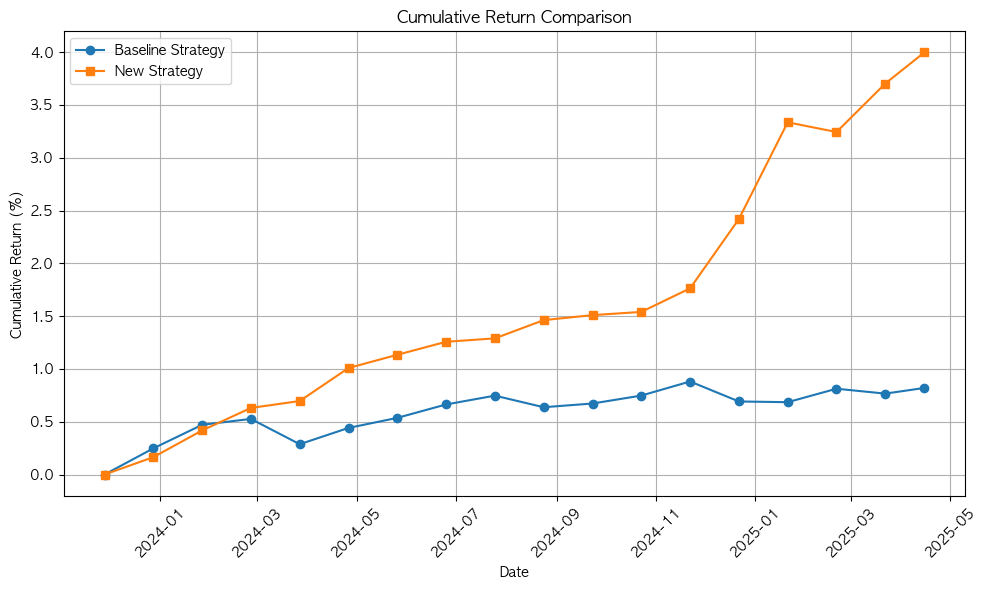

In [136]:
plt.figure(figsize=(10, 6))
plt.plot(df_base.index, df_base["Cumulative Return (%)"], label="Baseline Strategy", marker="o")
plt.plot(df_mine.index, df_mine["Cumulative Return (%)"], label="New Strategy", marker="s")
plt.title("Cumulative Return Comparison")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (%)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [145]:
df

,Cumulative Return (%),Monthly Return (%)
Exit Time,,
2023-11-28,0.000000,0.000000
2023-12-28,0.247978,0.247978
2024-01-27,0.470892,0.222914
2024-02-26,0.526926,0.056034
2024-03-27,0.287210,-0.239716
2024-04-26,0.441518,0.154308
2024-05-26,0.536740,0.095222
2024-06-25,0.663731,0.126991
2024-07-25,0.747214,0.083483


In [146]:
df2

,Cumulative Return (%),Monthly Return (%)
Exit Time,,
2023-11-28,0.000000,0.000000
2023-12-28,0.164612,0.164612
2024-01-27,0.417670,0.253058
2024-02-26,0.630881,0.213211
2024-03-27,0.696205,0.065324
2024-04-26,1.008641,0.312435
2024-05-26,1.134221,0.125580
2024-06-25,1.257283,0.123062
2024-07-25,1.289444,0.032161


In [143]:
# 4. 성과 지표 계산 함수 (Sharpe, MDD)
def compute_metrics(df, label):

    monthly_returns = df['Monthly Return (%)'].copy()
    
    # Sharpe Ratio (annualized)
    if monthly_returns.std() != 0:
        sharpe_ratio = (monthly_returns.mean() / monthly_returns.std()) * np.sqrt(12)
    else:
        sharpe_ratio = np.nan
    
    # MDD 계산
    cumulative = df["Cumulative Return (%)"]
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    mdd = drawdown.min()
    
    return {"Strategy": label, "Sharpe Ratio": sharpe_ratio, "MDD": mdd}

df = df_base.copy()
df2 = df_mine.copy()
df['Monthly Return (%)'] = df['Cumulative Return (%)'].diff()
df.fillna(0, inplace=True)
df2['Monthly Return (%)'] = df2['Cumulative Return (%)'].diff()
df2.fillna(0, inplace=True)

# 5. 지표 테이블 출력
metrics = pd.DataFrame([
    compute_metrics(df, "Baseline Strategy"),
    compute_metrics(df2, "New Strategy"),
])

metrics

,Strategy,Sharpe Ratio,MDD
0,Baseline Strategy,1.220520,-0.454933
1,New Strategy,3.108245,-0.027612
